In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/risk-management-uiim/train_part1.pkl
/kaggle/input/risk-management-uiim/train_part2.pkl
/kaggle/input/risk-management-uiim/submission.csv
/kaggle/input/risk-management-uiim/test_data.pkl


In [3]:
data_p1_link = '/kaggle/input/risk-management-uiim/train_part1.pkl'
data_p2_link = '/kaggle/input/risk-management-uiim/train_part2.pkl'
data_test_link = '/kaggle/input/risk-management-uiim/test_data.pkl'
submission_link = '/kaggle/input/risk-management-uiim/submission.csv'

In [4]:
data_p1 = pd.read_pickle(data_p1_link)

In [5]:
data_p1.shape

(763801, 648)

In [6]:
color_palette = sns.color_palette("bright")
colors = (color_palette[3], color_palette[0], color_palette[-1], color_palette[2], color_palette[4])

## Drop Constand Columns

In [7]:
def drop_constant_column(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

In [8]:
data_p1 = drop_constant_column(data_p1)

## Drop columns with more than 90% of missing values

In [9]:
cols_to_leave = data_p1.columns[data_p1.isna().sum() / data_p1.shape[0] < 0.9]
data_p1 = data_p1[cols_to_leave]

---

# 1. General EDA

### 1.1 Adding Timedepndent Feature `loand duration(days)`.
Suppose that more days lead to higher risk.

In [10]:
[(i, data_p1[i].dtype) for i in data_p1.columns if data_p1[i].dtype == '<M8[ns]']

[('REPORT_DT', dtype('<M8[ns]')), ('x_9', dtype('<M8[ns]'))]

In [11]:
data_p1[['REPORT_DT', 'x_9']].head()

,REPORT_DT,x_9
0,2019-08-25,2017-03-20
1,2019-06-27,2017-02-02
2,2018-01-09,2017-09-20
3,2019-09-03,2015-02-06
4,2017-12-18,2014-10-13


In [12]:
data_p1['loan_duration'] = pd.to_numeric(data_p1['REPORT_DT'] - data_p1['x_9']) / 8.64e+13

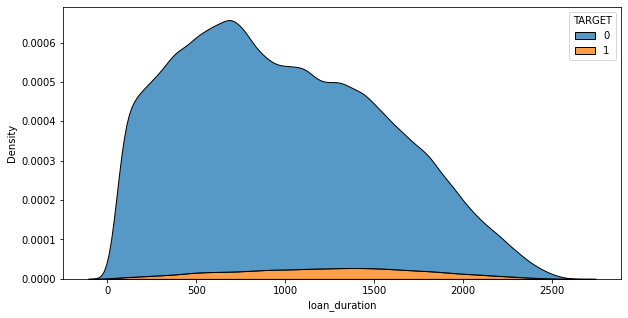

In [13]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=data_p1, x='loan_duration', hue='TARGET', multiple='stack')
plt.show()

In [14]:
data_p1_nodefault = data_p1[data_p1['TARGET'] == 1]
data_p1_default = data_p1[data_p1['TARGET'] == 0]

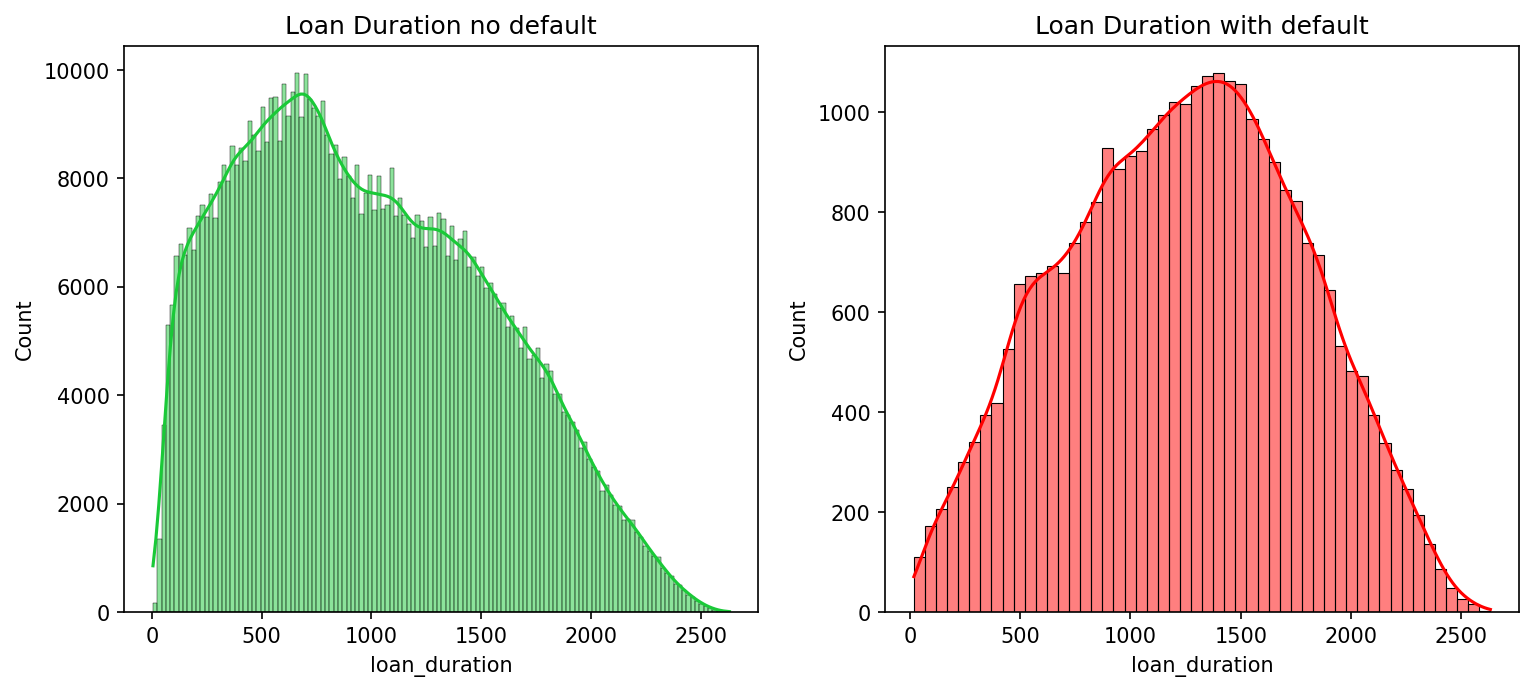

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), dpi=150)
sns.histplot(data_p1_default['loan_duration'], ax=ax[0], kde=True,  color=color_palette[2])
sns.histplot(data_p1_nodefault['loan_duration'], ax=ax[1], kde=True, color='r')
ax[0].set_title('Loan Duration no default')
ax[1].set_title('Loan Duration with default')
plt.show()

### 1.2 Investigating categorical features

In [16]:
obj_cols = [i for i in data_p1.columns if data_p1[i].dtype == 'O']
int_cols = [i for i in data_p1.columns if data_p1[i].dtype == int]
flaot_cols = [i for i in data_p1.columns if data_p1[i].dtype == float]

In [17]:
data_p1[obj_cols].head()

,x_12,x_13,x_18,x_19,x_21,x_614,x_615,x_617,x_618,x_625,x_628,x_634
0,B1,4,Пн,1,Приобретение,1,1,4,Приобретение,living in city in apart,ЗП,0
1,B1,4,Чт,1,Приобретение,0,1,4,Приобретение,other,ЗП,0
2,D,1,Ср,0,Инвестирование,1,0,1,Инвестирование,living in city in apart,Улица,1
3,N,4,Пт,0,Приобретение,1,0,4,Приобретение,living in city in apart,Улица,1
4,A,1,Пн,0,Инвестирование,1,0,1,Инвестирование,living in city in apart,Сотрудники,1


#### 1.2.1 `x_21` - loan goal feature

In [18]:
data_p1["x_21"].value_counts()

Приобретение                               524206
Инвестирование                             224016
Рефинансирование                             6968
Индивидуальное строительство                 4583
Нецелевой кредит под залог недвижимости      4028
Name: x_21, dtype: int64

In [19]:
defalt_to_goals = data_p1.groupby('x_21')["TARGET"].mean() * 100

defalt_to_goals  = defalt_to_goals.sort_values(ascending =False)

In [20]:
defalt_to_goals

x_21
Индивидуальное строительство               8.640628
Нецелевой кредит под залог недвижимости    6.057597
Приобретение                               4.613453
Инвестирование                             2.844886
Рефинансирование                           0.990241
Name: TARGET, dtype: float64

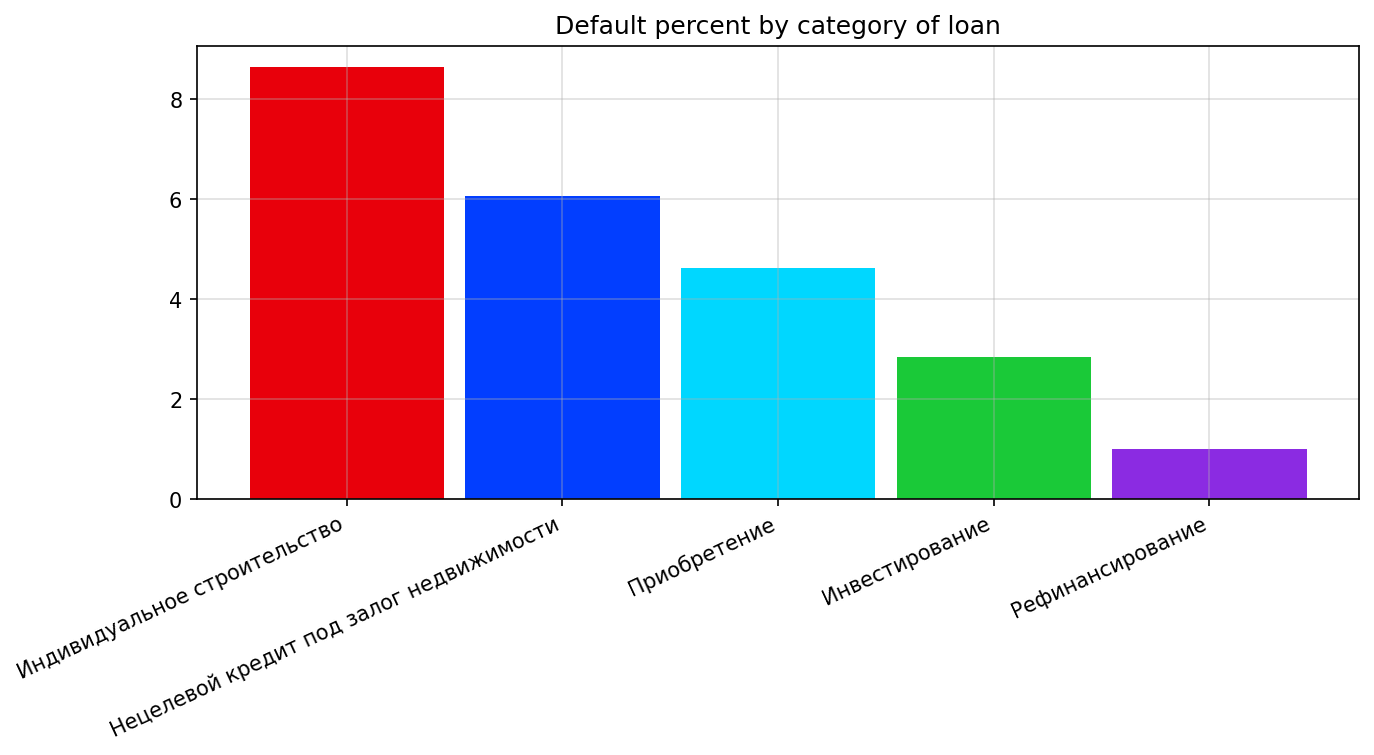

In [21]:
plt.figure(figsize=(10, 4), dpi=150)
plt.bar(x=defalt_to_goals.index,
        height=defalt_to_goals.values,
        color=colors,
        width = .9)
plt.xticks(rotation=25, ha='right', fontsize=10)
plt.grid(alpha=.4)
plt.title('Default percent by category of loan')
plt.show()

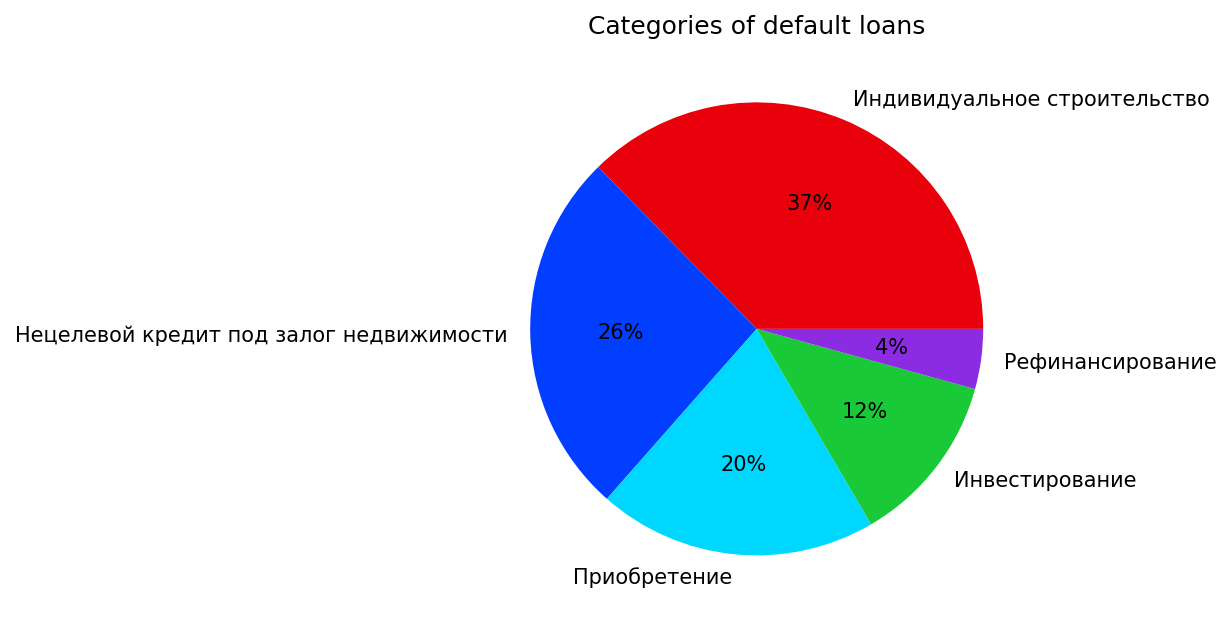

In [22]:
plt.figure(figsize=(5,5), dpi=150)
plt.pie(defalt_to_goals, labels = defalt_to_goals.index, colors = colors, autopct='%.0f%%')
plt.title('Categories of default loans')
plt.show()

### 1.2.2 `x_615` - gender, most probably

In [23]:
data_p1["x_615"].value_counts()

1    395696
0    368105
Name: x_615, dtype: int64

In [24]:
defalt_to_sex = data_p1.groupby('x_615')["TARGET"].mean() * 100

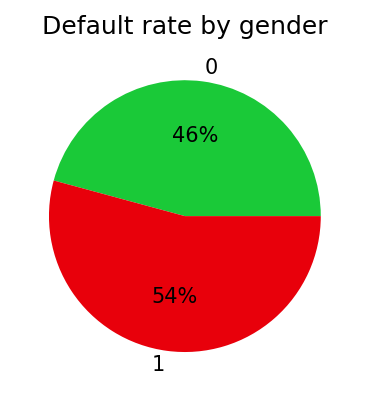

In [25]:
plt.figure(figsize=(3,3), dpi=150)
plt.pie(defalt_to_sex,
        labels = defalt_to_sex.index, colors=sns.color_palette("bright")[2:], autopct='%.0f%%')
plt.title('Default rate by gender')
plt.show()

### 1.2.3 `x_628` - показывает, является ли заемщик:
1. Держателем карты Сбера (зарплатный проект)
2. Сотрудником сбера
3. Не пользуется картой сбера

In [26]:
data_p1["x_628"].value_counts()

ЗП            394649
Улица         344020
Сотрудники     25132
Name: x_628, dtype: int64

In [27]:
defalt_to_carthold = data_p1.groupby('x_628')["TARGET"].mean() * 100
defalt_to_carthold  = defalt_to_carthold.sort_values(ascending =False)
print(defalt_to_carthold)

x_628
Улица         4.962502
ЗП            3.400997
Сотрудники    3.071781
Name: TARGET, dtype: float64


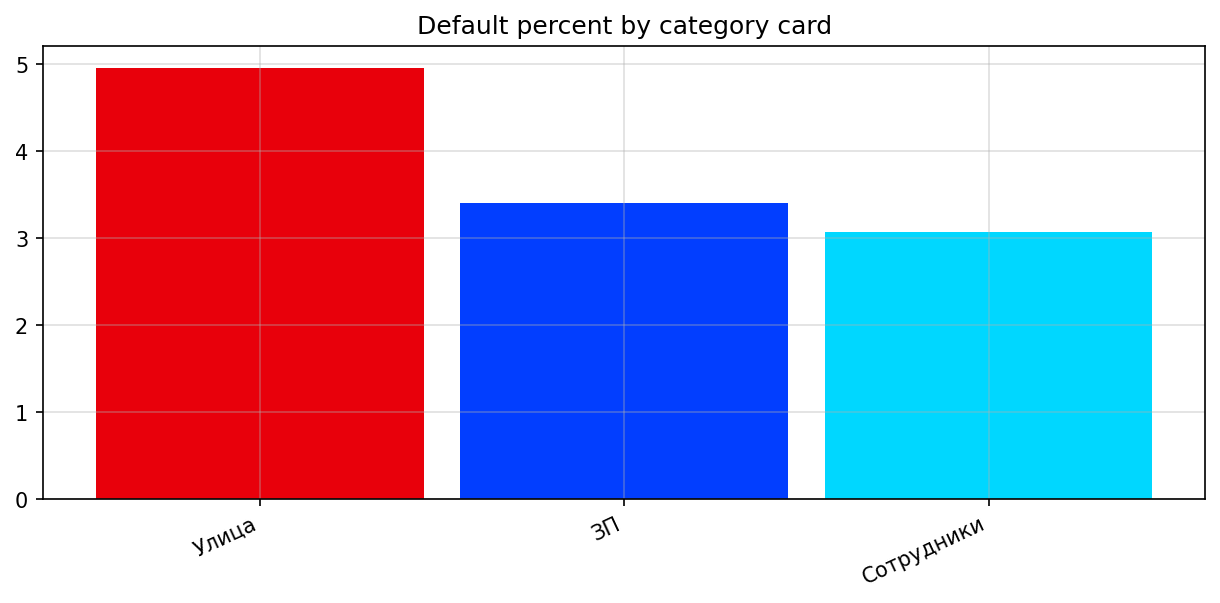

In [28]:
plt.figure(figsize=(10, 4), dpi=150)
plt.bar(x=defalt_to_carthold.index,
        height=defalt_to_carthold.values,
        color=colors,
        width = .9)
plt.xticks(rotation=25, ha='right', fontsize=10)
plt.grid(alpha=.4)
plt.title('Default percent by category card')
plt.show()

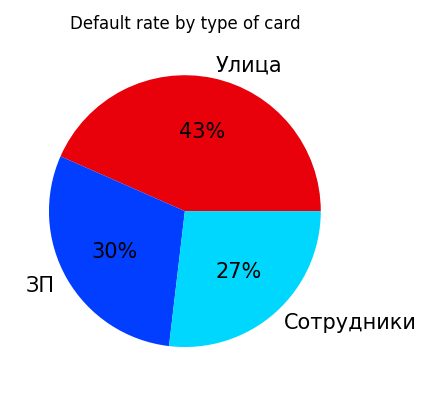

In [29]:
plt.figure(figsize=(3,3), dpi=150)
plt.pie(defalt_to_carthold,
        labels = defalt_to_carthold.index, colors=colors, autopct='%.0f%%')
plt.title('Default rate by type of card', fontsize=8)
plt.show()

### 1.2.4 `x_625` - shows whether the borrower lives in the city or outside the city

In [30]:
data_p1["x_625"].value_counts()

living in city in apart    497736
other                      266065
Name: x_625, dtype: int64

In [31]:
defalt_to_housing = data_p1.groupby('x_625')["TARGET"].mean() * 100
defalt_to_housing  = defalt_to_housing.sort_values(ascending =False)
print(defalt_to_housing)

x_625
other                      4.947287
living in city in apart    3.637069
Name: TARGET, dtype: float64


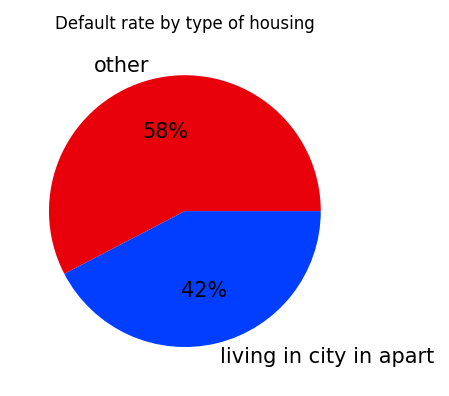

In [32]:
plt.figure(figsize=(3,3), dpi=150)
plt.pie(defalt_to_housing,
        labels = defalt_to_housing.index, colors=colors, autopct='%.0f%%')
plt.title('Default rate by type of housing', fontsize=8)
plt.show()

# EDA conclusion
As we may see from the presented data exploration, several categorical features may significantly affect in default rate. The most important ones are:

`x21` - which demonstrates the goal of the particular loan in this case category of 'Individual building' is the riskiest, with a huge default rate of 8.6% compared to ~4.5% of the mean default rate.

`x_628`- which shows which type of card the borrower has. In this case, the riskiest category is people who a not a cardholder of Sber with a default rate ~5% and obviously the least risky category is Sber employees.

`x_625` - which shows whether the borrower leave in the city also shows a quite significant difference of 4.94% for borrowers who live somewhere else compare to 3.63% for borrowers living in the city.



In [33]:
del data_p1_nodefault
del data_p1_default

---